In [1]:
# @title Import Files

!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
!cp kaggle.json ~/.kaggle/

# Set the permissions
!chmod 600 ~/.kaggle/kaggle.json

# Verify the kaggle.json file is in the correct location
!ls ~/.kaggle

# Download the dataset from Kaggle
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

# Extract the dataset
import zipfile
import os

zip_file_path = '/content/semantic-segmentation-of-aerial-imagery.zip'
extract_to_path = '/content/semantic-segmentation-of-aerial-imagery/'

os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print('Dataset extracted successfully')

# Verify the extraction
extracted_files = os.listdir(extract_to_path)
print(extracted_files)

Saving kaggle.json to kaggle.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
License(s): CC0-1.0
 98% 29.0M/29.6M [00:02<00:00, 21.2MB/s]
100% 29.6M/29.6M [00:02<00:00, 12.5MB/s]
Dataset extracted successfully
['Semantic segmentation dataset']


In [2]:
!pip install patchify

In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import torch
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# Semantic Segmentation of Aereal images of Earth with U-Net

**Implementation of a complete pipeline for training a U-Net model for semantic segmentation on aerial imagery, processing the images and masks, predicting new images, and evaluating the model's performance.**

## Dataset Information

https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 8 larger Tiles. Each <b>Tile</b> has folder <b>images</b> and <b>masks</b>.

The classes are:

- Building: #3C1098
- Land (unpaved area): #8429F6
- Road: #6EC1E4
- Vegetation: #FEDD3A
- Water: #E2A929
- Unlabeled: #9B9B9B

Main challenges:

1. class colors are hex, and masks are RGB
2. The Dataset is small - 72 images
3. Each tile has different height and width

Approach - cut but not resize

Tile 1 797 x 644 -> 768 x 512 -> 6 \\
Tile 2 509 x 544 -> 512 x 256 -> 2 \\
Tile 3 682 x 658 -> 512 x 512 -> 4 \\
Tile 4 1099 x 846 --> 1024 x 768 -> 12 \\
Tile 5 1126 x 1058 --> 1024 x 1024 -> 16 \\
Tile 6 859 x 838 --> 768 x 768 -> 9 \\
Tile 7 1817 x 2061 -> 1972 x 2048 -> 50 \\
Tile 8 2149 x 1479 -> 2048 x 1280 -> 40 \\

\\

<b>Image and Mask Patching:</b> The code navigates through the specified directory to load images and masks. Each image and its corresponding mask are resized to dimensions divisible by 256x256 (patch size). The images are then split into smaller patches using patchify, which divides the large image into manageable pieces for the neural network to process. This helps in handling large images and reducing memory consumption during training.

<b>Normalization:</b> Images are scaled using MinMaxScaler to transform pixel values to a range [0, 1]. This helps in stabilizing and speeding up the training process.

## Preprocessing

In [4]:
def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name, exist_ok=True)

In [5]:
scaler = MinMaxScaler()
root_dir = '/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/'
patch_size = 256

In [6]:
image_dataset=[]
for path, subdirs, files in os.walk(root_dir):
    dirname = path.split(os.path.sep)[-1]
    if dirname == "images":
        images = sorted(os.listdir(path))  # Sorting the list of image files
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                image_path = os.path.join(path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                # Crop
                # Height Width Channel
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))

                image = np.array(image)

                patches_img = patchify(image,(patch_size,patch_size,3),step=patch_size)
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:]
                        # img need flatten
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)


mask_dataset =[]
for path, subdirs, files in os.walk(root_dir):
    dirname = path.split(os.path.sep)[-1]
    if dirname == "masks":
        masks = sorted(os.listdir(path))  # Sorting the list of mask files
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                mask_path = os.path.join(path, mask_name)
                mask = cv2.imread(mask_path, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)

                patches_mask = patchify(mask,(patch_size,patch_size,3),step = patch_size)

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]
                        mask_dataset.append(single_patch_mask)

In [7]:
image_dataset =np.asarray(image_dataset)
mask_dataset =np.asarray(mask_dataset)
image_dataset.shape

(1305, 256, 256, 3)

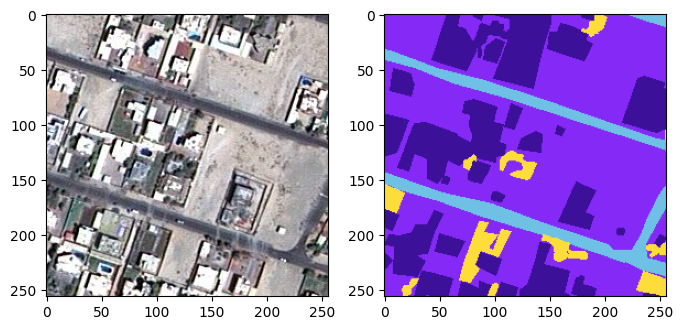

In [8]:
import random
import numpy as np
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

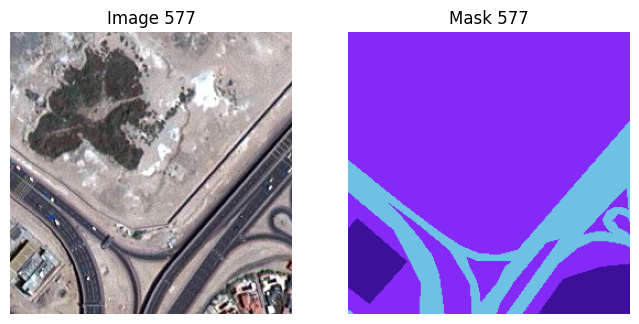

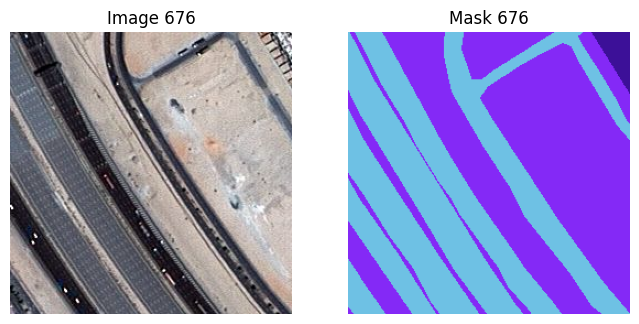

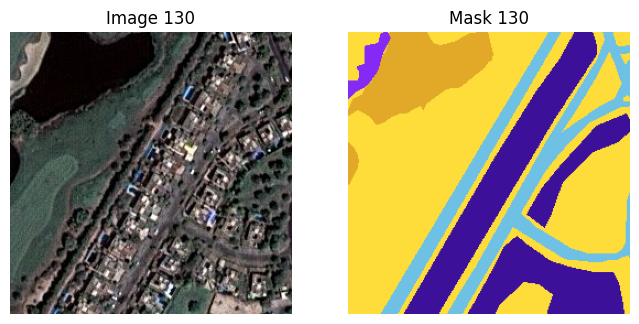

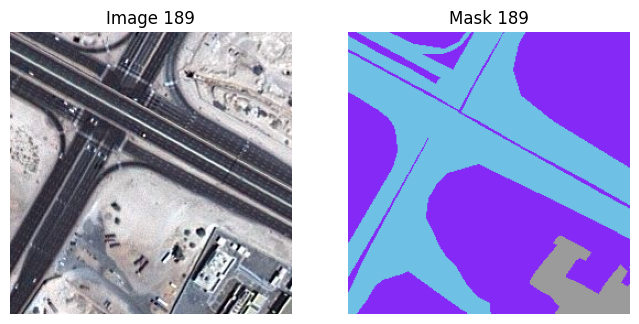

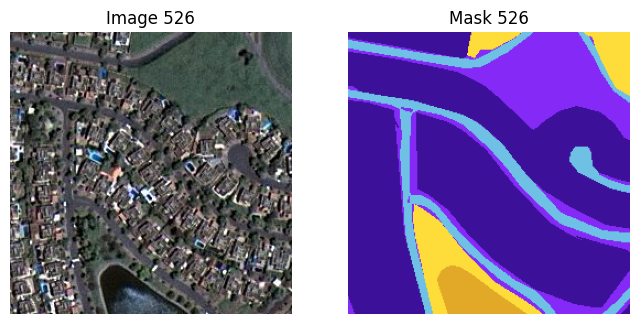

In [9]:
num_pairs = 5
patch_size = 256

for _ in range(num_pairs):
    image_number = random.randint(0, len(image_dataset) - 1)
    plt.figure(figsize=(8, 4))

    plt.subplot(121)
    plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
    plt.title(f'Image {image_number}')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
    plt.title(f'Mask {image_number}')
    plt.axis('off')

    plt.show()

**Convert Mask Color** \\
Masks Conversion: Mask images, which are initially in RGB format with specific colors representing different classes, are converted to a categorical format using a custom function rgb_to_2D_label. Each color is mapped to a specific class label (e.g., building, road, vegetation), and then converted into a one-hot encoded format suitable for classification.

In [10]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [11]:
def rgb_to_2D_label(label,num_class=6):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]


    new_label = np.zeros(label_seg.shape + (num_class,))


    for i in range(num_class):
        new_label[label_seg == i,i] = 1
    label_seg=new_label

    return label_seg

In [12]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)


labels = np.array(labels)

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0. 1.]


In [13]:
image_dataset[0].shape,labels.shape

((256, 256, 3), (1305, 256, 256, 6))

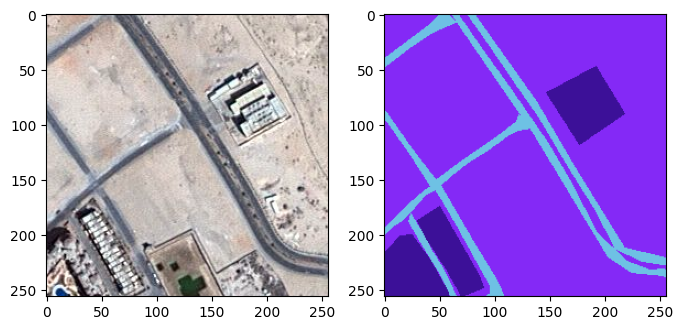

In [14]:
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

## Dataset


Custom Dataset Class (Aerial): A custom Dataset class is defined for loading images and masks, which allows integration with PyTorch's DataLoader to efficiently handle batching, shuffling, and other data handling operations during training. Train-Validation Split: The dataset is split into training and validation sets to evaluate the model's performance on unseen data.

In [15]:
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
class Aerial(Dataset):
    def __init__(self,images,maskes):
        super(Aerial,self).__init__()
        self.images = images
        self.masks = maskes
        self.n_samples =len(images)

    def __getitem__(self,index):
        image = self.images[index]
        image = image/255.0
        image = np.transpose(image,(2,0,1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        mask = self.masks[index]
        mask = np.transpose(mask,(2,0,1))
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image,mask

    def __len__(self):
        return self.n_samples

## Hyperparameters

In [16]:
create_dir("files/")
create_dir("Results/")
H = 256
W = 256
num_class = len(np.unique(labels))
size =(H,W)
batch_size = 2
num_epochs = 50
lr=1e-4
checkpoints_path ="files/checkpoints.pth"

## Model

In [17]:
from sklearn.model_selection import train_test_split
train_x,val_x,train_y,val_y = train_test_split(image_dataset,labels,test_size=0.2, random_state = 42)

train_dataset = Aerial(train_x,train_y)
val_dataset = Aerial(val_x,val_y)

In [18]:
# from sklearn.model_selection import StratifiedKFold

# # Assuming image_dataset and labels are your datasets
# num_folds = 5
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# # Convert the 2D label back to 1D for stratified splitting
# flat_labels = np.argmax(labels, axis=-1).reshape(-1, patch_size * patch_size).sum(axis=1)

# fold_metrics = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(image_dataset, flat_labels)):
#     print(f'Fold {fold + 1}/{num_folds}')

#     # Split the data
#     train_x, val_x = image_dataset[train_idx], image_dataset[val_idx]
#     train_y, val_y = labels[train_idx], labels[val_idx]

#     # Create datasets and dataloaders
#     train_dataset = Aerial(train_x, train_y)
#     val_dataset = Aerial(val_x, val_y)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [19]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle = True,
    num_workers=2,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [20]:
import torch.nn as nn
import torch
import torchvision


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.2):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.2):
        super(UNet, self).__init__()
        self.conv1 = DoubleConv(in_ch, 64, dropout)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128, dropout)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256, dropout)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512, dropout)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024, dropout)

        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512, dropout)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256, dropout)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128, dropout)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64, dropout)

        self.conv10 = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)

        out = F.softmax(c10, dim=1)
        return out

In [21]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0

        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()

        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)

        dice_losses = []
        for channel in range(num_channels):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            dice_loss_channel = self.forward(input_channel, target_channel)
            dice_losses.append(dice_loss_channel)

        average_dice_loss = torch.mean(torch.stack(dice_losses))

        return average_dice_loss

In [22]:
def global_accuracy(output, target):
    with torch.no_grad():
        _, preds = torch.max(output, 1)
        preds = preds.view(-1)
        target = torch.argmax(target, dim=1).view(-1)
        correct = torch.eq(preds, target).sum().item()
        total = target.numel()
        accuracy = (correct / total) * 100  # Convert to percentage
        return accuracy

In [24]:
class Recall(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(Recall, self).__init__()
        self.epsilon = epsilon

    def forward(self, input, target):
        input = torch.sigmoid(input)
        true_positives = (input * target).sum(dim=(2, 3))
        actual_positives = target.sum(dim=(2, 3))
        recall = (true_positives + self.epsilon) / (actual_positives + self.epsilon)
        return recall.mean(dim=0)

    def calculate_mean_recall(self, inputs, targets):
        recalls = []
        for channel in range(inputs.size(1)):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            recall = self.forward(input_channel, target_channel)
            recalls.append(recall)
        mean_recall = torch.stack(recalls).mean(dim=0)
        return mean_recall

In [25]:
model = UNet(3, 6, dropout=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
loss_fn = DiceLoss()
recall_metric = Recall()

In [26]:
import pandas as pd
from tqdm import tqdm

def train(model, loader, loss_fn, optimizer, device, recall_metric):
    model.train()
    total_loss, total_recall, total_accuracy = 0, 0, 0
    count = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


        recall = recall_metric(outputs, y)
        accuracy = global_accuracy(outputs, y)
        total_recall += recall.mean().item()
        total_accuracy += accuracy
        count += 1

    return total_loss / count, total_recall / count, total_accuracy / count

def validate(model, loader, loss_fn, device, recall_metric):
    model.eval()
    total_loss, total_recall, total_accuracy = 0, 0, 0
    count = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()


            recall = recall_metric(outputs, y)
            accuracy = global_accuracy(outputs, y)
            total_recall += recall.mean().item()
            total_accuracy += accuracy
            count += 1

    return total_loss / count, total_recall / count, total_accuracy / count

In [27]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch.nn.functional as F

metrics = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_recall": [],
    "val_recall": [],
    "train_accuracy": [],
    "val_accuracy": []
}

best_scores = {
    "train_loss": float('inf'),
    "val_loss": float('inf'),
    "train_recall": 0,
    "val_recall": 0,
    "train_accuracy": 0,
    "val_accuracy": 0
}

best_epochs = {
    "train_loss": 0,
    "val_loss": 0,
    "train_recall": 0,
    "val_recall": 0,
    "train_accuracy": 0,
    "val_accuracy": 0
}

best_score = float('inf')

for epoch in range(num_epochs):
    train_loss, train_avg_recall, train_avg_accuracy = train(model, train_loader, loss_fn, optimizer, device, recall_metric)
    val_loss, val_avg_recall, val_avg_accuracy = validate(model, val_loader, loss_fn, device, recall_metric)

    # Append metrics for this epoch
    metrics["epoch"].append(epoch + 1)
    metrics["train_loss"].append(train_loss)
    metrics["val_loss"].append(val_loss)
    metrics["train_recall"].append(train_avg_recall)
    metrics["val_recall"].append(val_avg_recall)
    metrics["train_accuracy"].append(train_avg_accuracy)
    metrics["val_accuracy"].append(val_avg_accuracy)

    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Update best scores and epochs
    if train_loss < best_scores["train_loss"]:
        best_scores["train_loss"] = train_loss
        best_epochs["train_loss"] = epoch + 1
    if val_loss < best_scores["val_loss"]:
        best_scores["val_loss"] = val_loss
        best_epochs["val_loss"] = epoch + 1
    if train_avg_recall > best_scores["train_recall"]:
        best_scores["train_recall"] = train_avg_recall
        best_epochs["train_recall"] = epoch + 1
    if val_avg_recall > best_scores["val_recall"]:
        best_scores["val_recall"] = val_avg_recall
        best_epochs["val_recall"] = epoch + 1
    if train_avg_accuracy > best_scores["train_accuracy"]:
        best_scores["train_accuracy"] = train_avg_accuracy
        best_epochs["train_accuracy"] = epoch + 1
    if val_avg_accuracy > best_scores["val_accuracy"]:
        best_scores["val_accuracy"] = val_avg_accuracy
        best_epochs["val_accuracy"] = epoch + 1

    if val_loss < best_score:
        best_score = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), checkpoints_path)

print("Scores:")
for metric, score in best_scores.items():
    print(f'{metric.replace("_", " ").title()}: {score:.4f}')

Epoch 50/50
Scores:
Train Loss: 0.1317
Val Loss: 0.2216
Train Recall: 0.8142
Val Recall: 0.7947
Train Accuracy: 86.9042
Val Accuracy: 78.2142


## Prediction

In [29]:
REAL_img_path = "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg"
msk_path = "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/masks/image_part_001.png"

In [30]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

model = UNet(3,6)
model.load_state_dict(torch.load(checkpoints_path, map_location=device))

transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img = Image.open(REAL_img_path)

patch_size = 256
SIZE_X = (img.size[0] // patch_size) * patch_size
SIZE_Y = (img.size[1] // patch_size) * patch_size
large_img = img.crop((0, 0, SIZE_X, SIZE_Y))
large_img = np.array(large_img)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)
patches_img = patches_img[:, :, 0, :, :, :]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        single_patch_tensor = torch.from_numpy(single_patch_img).float()
        single_patch_tensor /= 255.0
        single_patch_tensor = single_patch_tensor.permute(2, 0, 1)

        single_patch_tensor = transform(single_patch_tensor).unsqueeze(0)

        with torch.no_grad():
            pred = model(single_patch_tensor)
        pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patch_size, patch_size])

unpatched_prediction = unpatchify(patched_prediction, (SIZE_Y, SIZE_X))

In [31]:
def label_to_rgb(predicted_image):

    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

    Road = '#6EC1E4'.lstrip('#')
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

    Vegetation =  'FEDD3A'.lstrip('#')
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

    Water = 'E2A929'.lstrip('#')
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

    Unlabeled = '#9B9B9B'.lstrip('#')
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))

    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled

    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

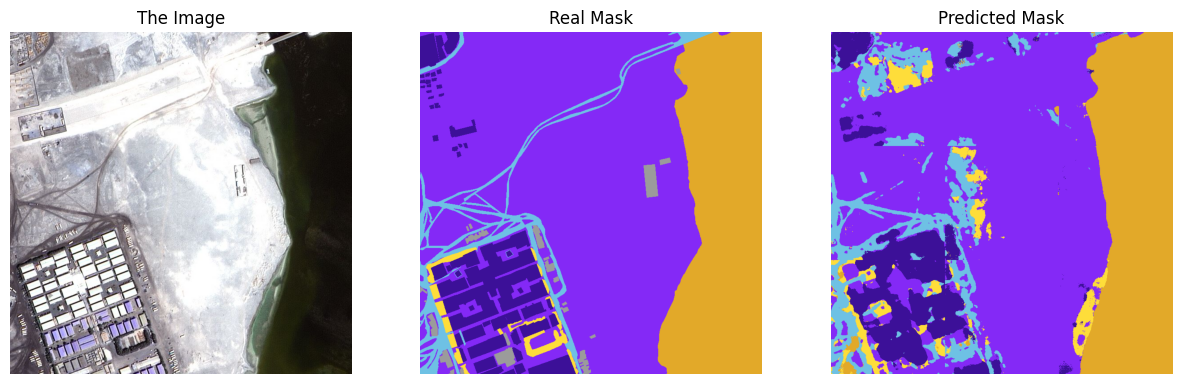

In [32]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


REAL_img = Image.open(REAL_img_path)
G_img = Image.open(msk_path)

patch_size = 256
SIZE_X = (REAL_img.size[0] // patch_size) * patch_size
SIZE_Y = (REAL_img.size[1] // patch_size) * patch_size
REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
REAL_img = np.array(REAL_img)
REAL_img = np.array(REAL_img)


patch_size = 256
SIZE_X = (G_img.size[0] // patch_size) * patch_size
SIZE_Y = (G_img.size[1] // patch_size) * patch_size
G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
G_img = np.array(G_img)


prediction = label_to_rgb(unpatched_prediction)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(REAL_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(G_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [33]:
import numpy as np
from PIL import Image

# Define the function to convert RGB mask to class labels
def rgb_to_2D_label(label, num_class=6):
    Building = np.array([60, 16, 152])
    Land = np.array([132, 41, 246])
    Road = np.array([110, 193, 228])
    Vegetation = np.array([254, 221, 58])
    Water = np.array([226, 169, 41])
    Unlabeled = np.array([155, 155, 155])

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == Road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == Water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 0]
    return label_seg

# Define the metric functions
def global_accuracy(prediction, ground_truth):
    correct = np.sum(prediction == ground_truth)
    total = prediction.size
    return correct / total

def mean_iou(prediction, ground_truth, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        true_cls = (ground_truth == cls)
        intersection = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        iou_list.append(iou)
    return np.nanmean(iou_list)

def recall(prediction, ground_truth, num_classes):
    recall_list = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        true_cls = (ground_truth == cls)
        true_positive = np.logical_and(pred_cls, true_cls).sum()
        false_negative = true_cls.sum() - true_positive
        if true_cls.sum() == 0:
            recall_value = float('nan')
        else:
            recall_value = true_positive / (true_positive + false_negative)
        recall_list.append(recall_value)
    return np.nanmean(recall_list)

# Load the ground truth mask and convert it to class labels
ground_truth = np.array(Image.open(msk_path))
ground_truth = rgb_to_2D_label(ground_truth)  # Convert RGB to class labels

# Ensure the prediction and ground truth have the same shape
if unpatched_prediction.shape != ground_truth.shape:
    min_shape = np.minimum(unpatched_prediction.shape, ground_truth.shape)
    unpatched_prediction = unpatched_prediction[:min_shape[0], :min_shape[1]]
    ground_truth = ground_truth[:min_shape[0], :min_shape[1]]

# Flatten the arrays for easier comparison
pred_flat = unpatched_prediction.flatten()
gt_flat = ground_truth.flatten()

# Number of classes
num_classes = 6

# Calculate metrics
global_acc = global_accuracy(pred_flat, gt_flat)
mean_iou_val = mean_iou(pred_flat, gt_flat, num_classes)
recall_val = recall(pred_flat, gt_flat, num_classes)

print(f"Global Accuracy: {global_acc * 100:.2f}%")
print(f"Mean IoU: {mean_iou_val * 100:.2f}%")
print(f"Recall: {recall_val * 100:.2f}%")

Global Accuracy: 80.44%
Mean IoU: 42.14%
Recall: 57.15%


In [34]:
REAL_img_path = "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg"
msk_path = "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/masks/image_part_005.png"

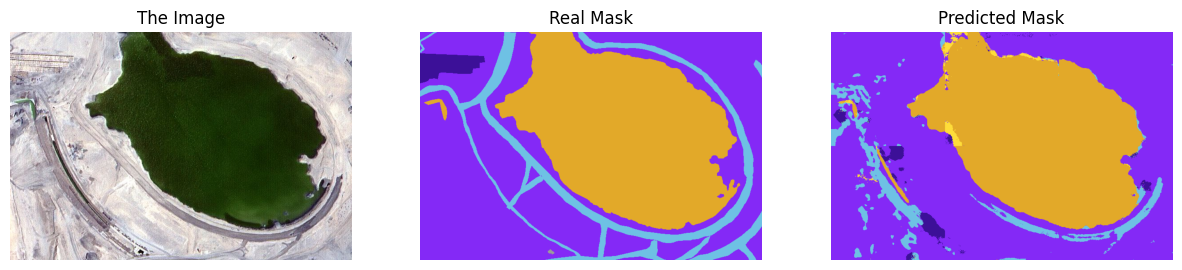

In [35]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

model = UNet(3, 6)
model.load_state_dict(torch.load(checkpoints_path, map_location=device))

transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img = Image.open(REAL_img_path)

patch_size = 256
SIZE_X = (img.size[0] // patch_size) * patch_size
SIZE_Y = (img.size[1] // patch_size) * patch_size
large_img = img.crop((0, 0, SIZE_X, SIZE_Y))
large_img = np.array(large_img)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)
patches_img = patches_img[:, :, 0, :, :, :]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        single_patch_tensor = torch.from_numpy(single_patch_img).float()
        single_patch_tensor /= 255.0
        single_patch_tensor = single_patch_tensor.permute(2, 0, 1)

        single_patch_tensor = transform(single_patch_tensor).unsqueeze(0)

        with torch.no_grad():
            pred = model(single_patch_tensor)
        pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patch_size, patch_size])

unpatched_prediction = unpatchify(patched_prediction, (SIZE_Y, SIZE_X))

def label_to_rgb(predicted_image):

    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

    Road = '#6EC1E4'.lstrip('#')
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

    Vegetation =  'FEDD3A'.lstrip('#')
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

    Water = 'E2A929'.lstrip('#')
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

    Unlabeled = '#9B9B9B'.lstrip('#')
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))

    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled

    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

    from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Load the images
REAL_img = Image.open(REAL_img_path)
G_img = Image.open(msk_path)


# Define patch size and adjust the size of G_img
patch_size = 256
SIZE_X = (REAL_img.size[0] // patch_size) * patch_size
SIZE_Y = (REAL_img.size[1] // patch_size) * patch_size
REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
REAL_img = np.array(REAL_img)
REAL_img = np.array(REAL_img)


patch_size = 256
SIZE_X = (G_img.size[0] // patch_size) * patch_size
SIZE_Y = (G_img.size[1] // patch_size) * patch_size
G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
G_img = np.array(G_img)


prediction = label_to_rgb(unpatched_prediction)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(REAL_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(G_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [36]:
import numpy as np
from PIL import Image

# Define the function to convert RGB mask to class labels
def rgb_to_2D_label(label, num_class=6):
    Building = np.array([60, 16, 152])
    Land = np.array([132, 41, 246])
    Road = np.array([110, 193, 228])
    Vegetation = np.array([254, 221, 58])
    Water = np.array([226, 169, 41])
    Unlabeled = np.array([155, 155, 155])

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == Road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == Water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 0]
    return label_seg

# Define the metric functions
def global_accuracy(prediction, ground_truth):
    correct = np.sum(prediction == ground_truth)
    total = prediction.size
    return correct / total

def mean_iou(prediction, ground_truth, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        true_cls = (ground_truth == cls)
        intersection = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        iou_list.append(iou)
    return np.nanmean(iou_list)

def recall(prediction, ground_truth, num_classes):
    recall_list = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        true_cls = (ground_truth == cls)
        true_positive = np.logical_and(pred_cls, true_cls).sum()
        false_negative = true_cls.sum() - true_positive
        if true_cls.sum() == 0:
            recall_value = float('nan')
        else:
            recall_value = true_positive / (true_positive + false_negative)
        recall_list.append(recall_value)
    return np.nanmean(recall_list)

# Load the ground truth mask and convert it to class labels
ground_truth = np.array(Image.open(msk_path))
ground_truth = rgb_to_2D_label(ground_truth)  # Convert RGB to class labels

# Ensure the prediction and ground truth have the same shape
if unpatched_prediction.shape != ground_truth.shape:
    min_shape = np.minimum(unpatched_prediction.shape, ground_truth.shape)
    unpatched_prediction = unpatched_prediction[:min_shape[0], :min_shape[1]]
    ground_truth = ground_truth[:min_shape[0], :min_shape[1]]

# Flatten the arrays for easier comparison
pred_flat = unpatched_prediction.flatten()
gt_flat = ground_truth.flatten()

# Number of classes
num_classes = 6

# Calculate metrics
global_acc = global_accuracy(pred_flat, gt_flat)
mean_iou_val = mean_iou(pred_flat, gt_flat, num_classes)
recall_val = recall(pred_flat, gt_flat, num_classes)

print(f"Global Accuracy: {global_acc * 100:.2f}%")
print(f"Mean IoU: {mean_iou_val * 100:.2f}%")
print(f"Recall: {recall_val * 100:.2f}%")

Global Accuracy: 83.22%
Mean IoU: 30.46%
Recall: 40.94%
